In [1]:
# Needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import sys
from datetime import datetime
import random
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import cv2
# Sklearn
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
# Torch
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
# TorchVision
from torchvision import models, transforms, datasets
from torchvision.utils import make_grid
# Albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
# Hyperopt
from hyperopt import hp
from hyperopt import fmin, tpe


device = torch.device('cuda')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
seed = 42
seed_everything(seed)

Preprocessing of DATA

In [5]:
df_train = pd.read_csv('/content/drive/MyDrive/Challenge1/trainset/trainset_true.csv')
df_train['GENDER'] = df_train.GENDER.apply(lambda x: int(x=='F'))
df_train['DOB'] = df_train['DOB'].apply(lambda x: x.replace("-", "/"))
df_train['AGE'] = df_train['DOB'].apply(lambda x: 2020-int(x.split("/")[-1]))

In [6]:
# sns.pairplot(df_train[['LABEL', 'GENDER', 'LYMPH_COUNT', "AGE"]])

In [7]:
df_test = pd.read_csv('/content/drive/MyDrive/Challenge1/testset/testset_data.csv')
df_test['GENDER'] = df_test.GENDER.apply(lambda x: int(x=='F'))
df_test['DOB'] = df_test['DOB'].apply(lambda x: x.replace("-", "/"))
df_test['AGE'] = df_test['DOB'].apply(lambda x: 2020-int(x.split("/")[-1]))
df_test.head()

,ID,LABEL,GENDER,DOB,LYMPH_COUNT,AGE
0,P71,-1,0,1/17/1946,5.76,74
1,P16,-1,0,3/5/1940,32.00,80
2,P114,-1,0,6/16/1929,4.60,91
3,P170,-1,0,11/3/1933,4.80,87
4,P98,-1,1,5/14/1970,6.24,50


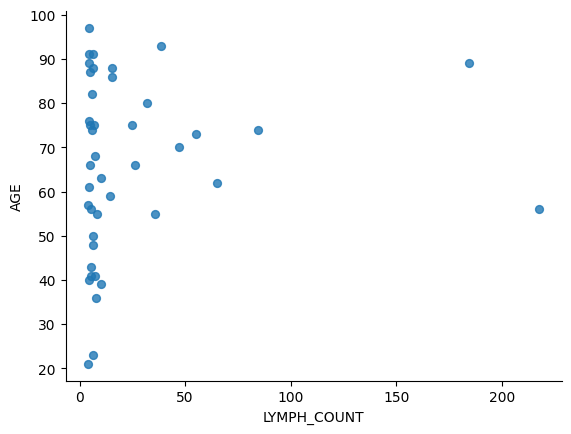

In [8]:
# @title LYMPH_COUNT vs AGE

from matplotlib import pyplot as plt
df_test.plot(kind='scatter', x='LYMPH_COUNT', y='AGE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

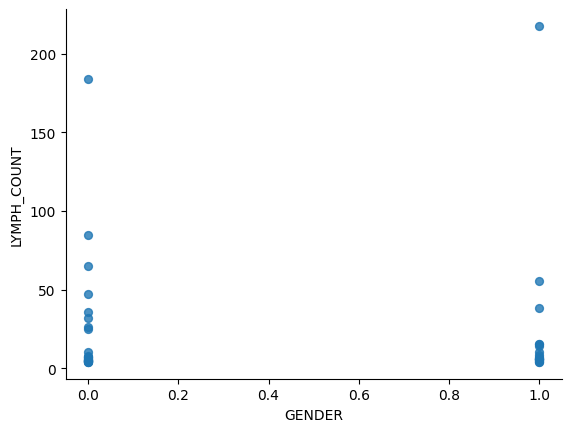

In [9]:
# @title GENDER vs LYMPH_COUNT

from matplotlib import pyplot as plt
df_test.plot(kind='scatter', x='GENDER', y='LYMPH_COUNT', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

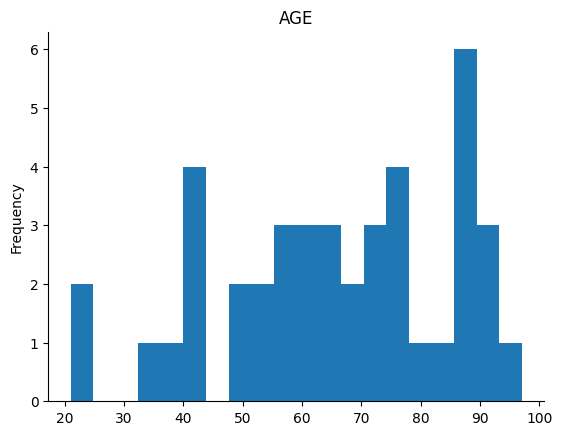

In [10]:
# @title AGE

from matplotlib import pyplot as plt
df_test['AGE'].plot(kind='hist', bins=20, title='AGE')
plt.gca().spines[['top', 'right',]].set_visible(False)

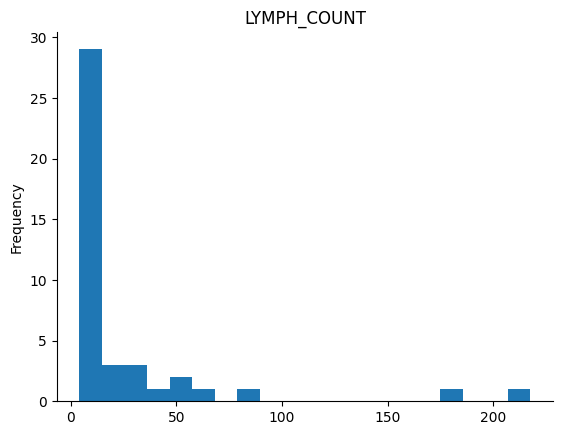

In [11]:
# @title LYMPH_COUNT

from matplotlib import pyplot as plt
df_test['LYMPH_COUNT'].plot(kind='hist', bins=20, title='LYMPH_COUNT')
plt.gca().spines[['top', 'right',]].set_visible(False)

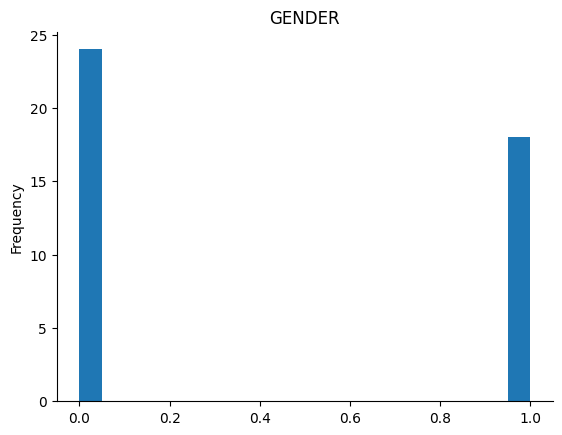

In [12]:
# @title GENDER

from matplotlib import pyplot as plt
df_test['GENDER'].plot(kind='hist', bins=20, title='GENDER')
plt.gca().spines[['top', 'right',]].set_visible(False)

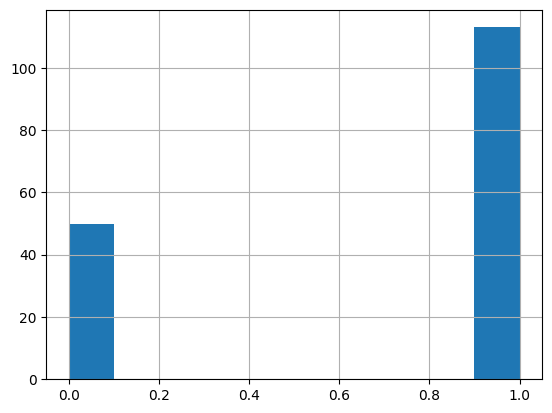

In [13]:
df_train.LABEL.hist()
plt.show()

# Baselines


Lymphocytes - counting



If the LYMPH_COUNT is less than or equal to a certain threshold value, assign the label 0.
If the LYMPH_COUNT is greater than the threshold value, assign the label 1.
This heuristic approach suggests using LYMPH_COUNT as a predictive feature to determine the label, with a threshold value chosen to separate the two classes based on their average LYMPH_COUNT values.

In [32]:
def lymph_count_predictor(thres=7): #tried values for 6, 5
    stratfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    split_scores = []
    for train_index, test_index in stratfold.split(df_train, df_train.LABEL):
        X_train, X_val = df_train.LYMPH_COUNT[train_index].values.reshape(-1, 1), df_train.LYMPH_COUNT[test_index].values.reshape(-1, 1)
        y_train, y_val = df_train.LABEL[train_index], df_train.LABEL[test_index]
        y_pred = [int(x>thres) for x in X_val]
    #     print("Balanced Accuracy Score", balanced_accuracy_score(y_val, y_pred))
        split_scores.append(balanced_accuracy_score(y_val, y_pred))
    return np.mean(split_scores)

In [15]:
print("Mean Balanced Accuracy",lymph_count_predictor(7.55)) #7.55

Mean Balanced Accuracy 0.8573913043478261


<ipython-input-14-7641a69def91>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred = [int(x>thres) for x in X_val]
<ipython-input-14-7641a69def91>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred = [int(x>thres) for x in X_val]
<ipython-input-14-7641a69def91>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred = [int(x>thres) for x in X_val]
<ipython-input-14-7641a69def91>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Final submission

In [33]:
# Create a DataFrame with predictions including the ID column
predictions = pd.DataFrame({'ID': df_test['ID'], 'Predicted': y_pred})

# Save predictions to CSV without index
predictions.to_csv('submission.csv', index=False)

score of 0.82337

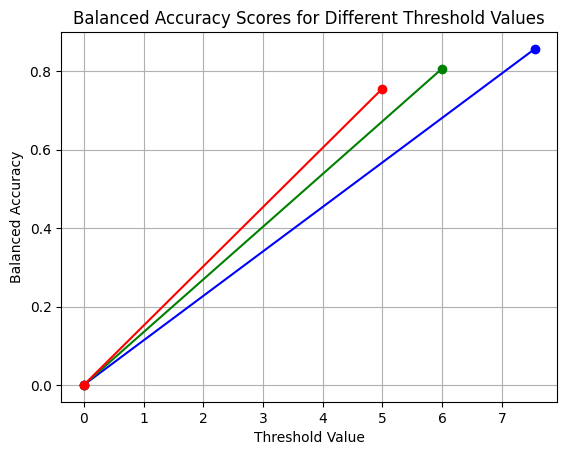

In [22]:
import matplotlib.pyplot as plt

# Data
threshold_values = [7.55, 6, 5]
balanced_accuracy_scores = [0.857, 0.807, 0.756]

# Colors for each line
colors = ['b', 'g', 'r']

# Plot each data point with a different color and connect with lines
for i in range(len(threshold_values)):
    plt.plot([0, threshold_values[i]], [0, balanced_accuracy_scores[i]], color=colors[i], marker='o', linestyle='-')

# Title and labels
plt.title('Balanced Accuracy Scores for Different Threshold Values')
plt.xlabel('Threshold Value')
plt.ylabel('Balanced Accuracy')

# Show grid
plt.grid(True)

# Show plot
plt.show()



### RandomForest -Classifier


In [18]:
def rf_classifier(space):

    n_estimators = space['n_estimators']
    min_samples_leaf = space['min_samples_leaf']
    max_depth = space['max_depth']
    class_weight = space['class_weight']


    stratfold = StratifiedKFold(n_splits=5)
    split_scores = []
    for train_index, test_index in stratfold.split(df_train, df_train.LABEL):
        X_train, X_val = df_train[["LYMPH_COUNT", "AGE", "GENDER"]].values[train_index], df_train[["LYMPH_COUNT", "AGE", "GENDER"]].values[test_index]
        y_train, y_val = df_train.LABEL[train_index], df_train.LABEL[test_index]
        clf = RandomForestClassifier(random_state=42, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_depth=max_depth, class_weight=class_weight, n_jobs=-1)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        split_scores.append(balanced_accuracy_score(y_val, y_pred))
    return 1-np.mean(split_scores)

Applying grid view to evaluate the best hyperparameter for random forest

In [34]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [100+i*100 for i in range(10)],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_depth': [5, 8, 15, 25, 30],
    'class_weight': [None, "balanced"]
}

# Create a random forest classifier
clf = RandomForestClassifier(random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='balanced_accuracy')
grid_search.fit(df_train[["LYMPH_COUNT", "AGE", "GENDER"]], df_train.LABEL)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best hyperparameters:", best_params)

Best hyperparameters: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 100}


In [35]:
clf_rf = RandomForestClassifier(**{'n_estimators':100,'min_samples_leaf':10,'max_depth':25,'class_weight':'balanced'})
clf_rf.fit(df_train[["LYMPH_COUNT", "AGE", "GENDER"]], df_train.LABEL)
y_pred_rf =  clf_rf.predict(df_test[["LYMPH_COUNT", "AGE", "GENDER"]])

In [36]:
1-rf_classifier({'n_estimators':100,'min_samples_leaf':10,'max_depth':25,'class_weight':'balanced'})

0.8721739130434782

# Ensembling rf + LR + cross validation


In [37]:
stratfold = StratifiedKFold(n_splits=5, shuffle=True)
split_scores = []
for train_index, test_index in stratfold.split(df_train, df_train.LABEL):
    X_train, X_val = df_train[["LYMPH_COUNT", "AGE"]].values[train_index], df_train[["LYMPH_COUNT", "AGE"]].values[test_index]
    y_train, y_val = df_train.LABEL[train_index], df_train.LABEL[test_index]
    clf_rf = RandomForestClassifier().fit(X_train, y_train)
    clf_logreg = LogisticRegression().fit(X_train, y_train)
    y_pred_det = [int(x>7) for x in X_val[:,0]]
    y_pred_logreg =  clf_logreg.predict(X_val)
    y_pred_rf =  clf_rf.predict(X_val)
    # Build final prediction
    y_pred = []
    for i in range(len(X_val)):
        prediction = np.argmax(np.bincount([y_pred_det[i], y_pred_logreg[i], y_pred_rf[i]]))
        y_pred.append(prediction)
    #print("Balanced Accuracy Score", balanced_accuracy_score(y_val, y_pred))
    split_scores.append(balanced_accuracy_score(y_val, y_pred))
print("Mean Balanced Accuracy", np.mean(split_scores))

Mean Balanced Accuracy 0.8466403162055336


In [38]:
clf_rf = RandomForestClassifier().fit(df_train[["LYMPH_COUNT", "AGE"]], df_train.LABEL)
clf_logreg = LogisticRegression().fit(df_train[["LYMPH_COUNT", "AGE"]], df_train.LABEL)

y_pred_det = [int(df_test.iloc[i,4]>7) for i in range(len(df_test))]
y_pred_logreg =  clf_logreg.predict(df_test[["LYMPH_COUNT", "AGE"]])
y_pred_rf =  clf_rf.predict(df_test[["LYMPH_COUNT", "AGE"]])

In [39]:
import pandas as pd

# Build final submissions
y_pred = []
for i in range(len(df_test)):
    prediction = np.argmax(np.bincount([y_pred_det[i], y_pred_logreg[i], y_pred_rf[i]]))
    y_pred.append(prediction)

# Create a DataFrame with predictions including the ID column
predictions = pd.DataFrame({'ID': df_test['ID'], 'Predicted': y_pred})

# Save predictions to CSV without index
predictions.to_csv('submission.csv', index=False)

ensemble method scores 0.75